In [ ]:
# Import library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision

In [19]:
# Parameters
BATCH_N= 192
LR= 1e-3
EPOCH= 50
LOG_IV= 100
CUDA= torch.cuda.is_available()

In [20]:
# Load data

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root = "../data/cifar/", 
                                 train= True, download = True, 
                                 transform=transforms.Compose([transforms.ToTensor()])),
    batch_size= BATCH_N, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root = "../data/cifar/", 
                                 train= False, download = True, 
                                 transform=transforms.Compose([transforms.ToTensor()])),
    batch_size= BATCH_N, shuffle=True, **kwargs)


Files already downloaded and verified
Files already downloaded and verified


In [21]:
# Define models
class ShallowNet(nn.Module):
    def __init__(self):
        super(ShallowNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 51, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(51 * 16 * 16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 22, 5, padding= 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(22, 35, 5, padding= 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(35, 75, 5, padding= 2),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(75 * 8 * 8, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

class DeeperNet(nn.Module):
    def __init__(self):
        super(DeeperNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 20, 5, padding= 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 25, 5, padding= 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(25, 31, 5, padding= 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(31, 46, 5, padding= 2),
            nn.ReLU(),
            nn.Conv2d(46, 50, 5, padding= 2),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(50 * 4 * 4, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

shallow = ShallowNet()
deep = DeepNet()
deeper = DeeperNet()
if CUDA:
    shallow= shallow.cuda()
    deep= deep.cuda()
    deeper= deeper.cuda()

In [22]:
# Count # of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_shallow = count_parameters(shallow)
count_deep = count_parameters(deep)
count_deeper = count_parameters(deeper)

print("parameters in shallow model:")
print(count_shallow)
print("parameters in deep model:")
print(count_deep)
print("parameters in deeper model:")
print(count_deeper)

parameters in shallow model:
134446
parameters in deep model:
134667
parameters in deeper model:
134707


In [23]:
optim_shallow = optim.Adam(params=shallow.parameters(),lr=LR)
optim_deep = optim.Adam(params=deep.parameters(),lr=LR)
optim_deeper = optim.Adam(params=deeper.parameters(),lr=LR)
criterion = nn.CrossEntropyLoss()

In [24]:
loss_shallow_hist= []
loss_deep_hist= []
loss_deeper_hist= []
acc_shallow_hist= []
acc_deep_hist= []
acc_deeper_hist= []

for epoch in range(EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        if CUDA:
            inputs, labels= inputs.cuda(), labels.cuda()
        inputs, labels= Variable(inputs), Variable(labels)
        
        optim_shallow.zero_grad()
        optim_deep.zero_grad()
        optim_deeper.zero_grad()
        
        outputs_shallow= shallow(inputs)
        outputs_deep= deep(inputs)
        outputs_deeper= deeper(inputs)
        
        loss_shallow= criterion(outputs_shallow, labels)
        loss_deep= criterion(outputs_deep, labels)
        loss_deeper= criterion(outputs_deeper, labels)
        
        loss_shallow.backward()
        loss_deep.backward()
        loss_deeper.backward()
        
        optim_shallow.step()
        optim_deep.step()
        optim_deeper.step()
        
        # recordings
        outputs_shallow = torch.max(outputs_shallow, 1)[1].data.squeeze()
        outputs_deep = torch.max(outputs_deep, 1)[1].data.squeeze()
        outputs_deeper = torch.max(outputs_deeper, 1)[1].data.squeeze()

        acc_shallow = sum(outputs_shallow == labels.data)/float(labels.size(0))
        acc_deep = sum(outputs_deep == labels.data)/float(labels.size(0))
        acc_deeper = sum(outputs_deeper == labels.data)/float(labels.size(0))
        
        loss_shallow_hist.append(loss_shallow.data[0])
        loss_deep_hist.append(loss_deep.data[0])
        loss_deeper_hist.append(loss_deeper.data[0])
        acc_shallow_hist.append(acc_shallow)
        acc_deep_hist.append(acc_deep)
        acc_deeper_hist.append(acc_deeper)
        if batch_idx % LOG_IV == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\nLoss: | {:.6f} | {:.6f} | {:.6f}   Acc:  | {:.6f} | {:.6f} | {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss_shallow.data[0], loss_deep.data[0], loss_deeper.data[0],
            acc_shallow, acc_deep, acc_deeper))
print('end of training')


Train Epoch: 0 [0/50000 (0%)]
Loss: | 2.309016 | 2.304037 | 2.302932   Acc:  | 0.057292 | 0.078125 | 0.088542
Train Epoch: 0 [19200/50000 (38%)]
Loss: | 1.476485 | 1.608055 | 1.800640   Acc:  | 0.489583 | 0.369792 | 0.348958
Train Epoch: 0 [38400/50000 (77%)]
Loss: | 1.342541 | 1.404923 | 1.556907   Acc:  | 0.541667 | 0.515625 | 0.468750
Train Epoch: 1 [0/50000 (0%)]
Loss: | 1.218088 | 1.278287 | 1.423488   Acc:  | 0.593750 | 0.536458 | 0.500000
Train Epoch: 1 [19200/50000 (38%)]
Loss: | 1.307189 | 1.261557 | 1.407447   Acc:  | 0.557292 | 0.552083 | 0.484375
Train Epoch: 1 [38400/50000 (77%)]
Loss: | 1.183253 | 1.146733 | 1.318911   Acc:  | 0.604167 | 0.572917 | 0.515625
Train Epoch: 2 [0/50000 (0%)]
Loss: | 1.138600 | 1.187186 | 1.252050   Acc:  | 0.588542 | 0.588542 | 0.546875
Train Epoch: 2 [19200/50000 (38%)]
Loss: | 1.164832 | 1.048765 | 1.112667   Acc:  | 0.604167 | 0.588542 | 0.588542
Train Epoch: 2 [38400/50000 (77%)]
Loss: | 1.154321 | 1.094144 | 1.271642   Acc:  | 0.604167 | 

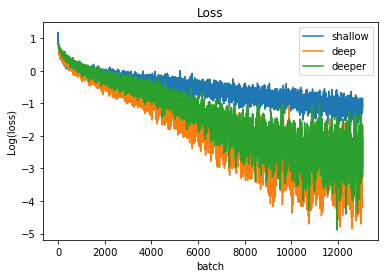

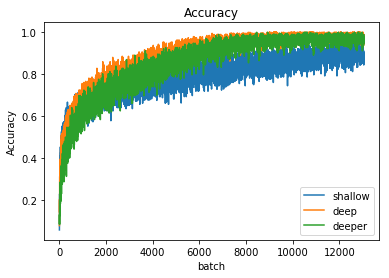

In [29]:
import matplotlib.pyplot as plt
import numpy as np
num_show = 13050
plt.plot(np.arange(num_show), np.log(np.array(loss_shallow_hist[:num_show])), label='shallow')
plt.plot(np.arange(num_show), np.log(np.array(loss_deep_hist[:num_show])), label='deep')
plt.plot(np.arange(num_show), np.log(np.array(loss_deeper_hist[:num_show])), label='deeper')
plt.title('Loss')
plt.xlabel('batch')
plt.ylabel('Log(loss)')
plt.legend()
plt.show()

plt.plot(np.arange(num_show), np.array(acc_shallow_hist[:num_show]), label='shallow')
plt.plot(np.arange(num_show), np.array(acc_deep_hist[:num_show]), label='deep')
plt.plot(np.arange(num_show), np.array(acc_deeper_hist[:num_show]), label='deeper')
plt.title('Accuracy')
plt.xlabel('batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()